# Reto Vanti - REVISAR EL FILTRADO DE DATA, SOBRE LOS 14 CONSUMOS



## Librerias a utilizar

Primero importamos las librerias necesarias que utilizaremos para el reto.

In [ ]:
import pandas as pd #Para trabajar con dataframes
import numpy as np #Para trabajar con los arrays de numpy

#Para visualización
import seaborn as sns #Para visualización
import matplotlib.pyplot as plt

#Para estadisticos
from scipy import stats
#import statsmodels.api as sm


#Para el modelado
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from datetime import datetime
from scipy.stats import chi2_contingency

## Entendimiento y preparación de los datos

Vamos primero a explorar con que información contamos para poder desarrollar el ejercicio.

In [ ]:
data = pd.read_csv('data_challenge.csv')

Tenemos 7 columnas con las que trabajar, vamos a revisar si estas columnas pueden sernos de ayuda para realizar nuestra predicción, pero primero vamos a explorarlas y ajustarlas para que nuestros modelos lo consuman.

In [ ]:
data.head()

,cuenta,fec_contab_documento,consumo,categoria_cliente,porcion,dias_fact,descrip_poblac_suministro
0,AATHHM6d7TyIT1ubMnB14A==,2023-04-22,0.0,60,P14,33,BOGOTA
1,AATHHM6d7TyIT1ubMnB14A==,2023-05-23,0.0,60,P14,27,BOGOTA
2,AATHHM6d7TyIT1ubMnB14A==,2023-06-23,0.0,60,P14,33,BOGOTA
3,AATHHM6d7TyIT1ubMnB14A==,2023-07-22,0.0,60,P14,27,BOGOTA
4,AATHHM6d7TyIT1ubMnB14A==,2023-08-23,0.0,60,P14,29,BOGOTA


In [ ]:
print(data["fec_contab_documento"].min())
print(data["fec_contab_documento"].max())

2023-03-06
2024-05-29


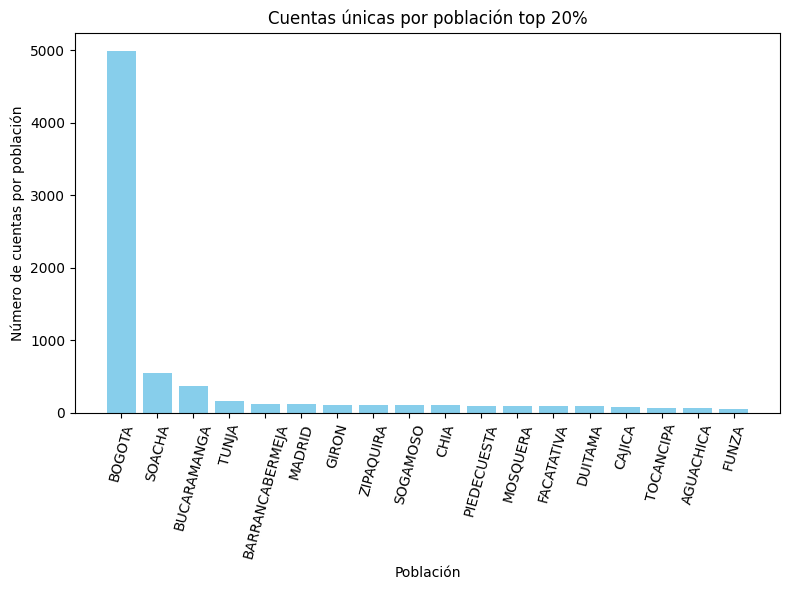

In [ ]:
conteo_por_clasificacion = data.groupby('descrip_poblac_suministro')['cuenta'].nunique()

top_n = int(len(conteo_por_clasificacion) * 0.2)
top_clasificaciones = conteo_por_clasificacion.sort_values(ascending=False).head(top_n)

plt.figure(figsize=(8, 6))
plt.bar(top_clasificaciones.index, top_clasificaciones.values, color='skyblue')

plt.title('Cuentas únicas por población top 20%')
plt.xlabel('Población')
plt.ylabel('Número de cuentas por población')

plt.xticks(rotation=75)
plt.tight_layout()
plt.show()

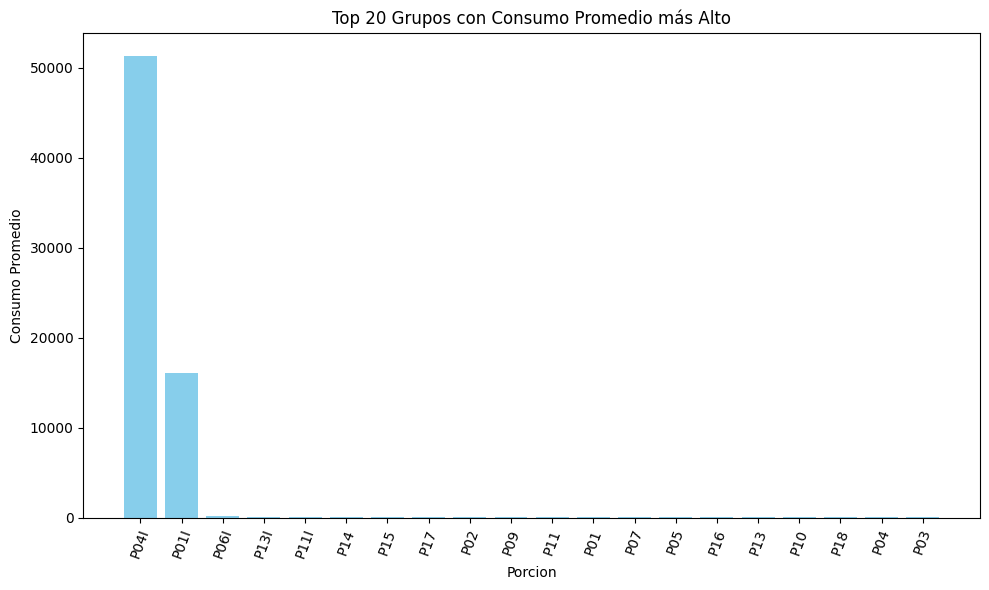

In [ ]:
consumo_promedio_por_grupo = data.groupby('porcion')['consumo'].mean()

top_n = 20
top_consumos_por_grupo = consumo_promedio_por_grupo.sort_values(ascending=False).head(top_n)

plt.figure(figsize=(10, 6))
plt.bar(top_consumos_por_grupo.index, top_consumos_por_grupo.values, color='skyblue')

plt.title('Top 20 Grupos con Consumo Promedio más Alto')
plt.xlabel('Porcion')
plt.ylabel('Consumo Promedio')

plt.xticks(rotation=70)
plt.tight_layout()
plt.show()

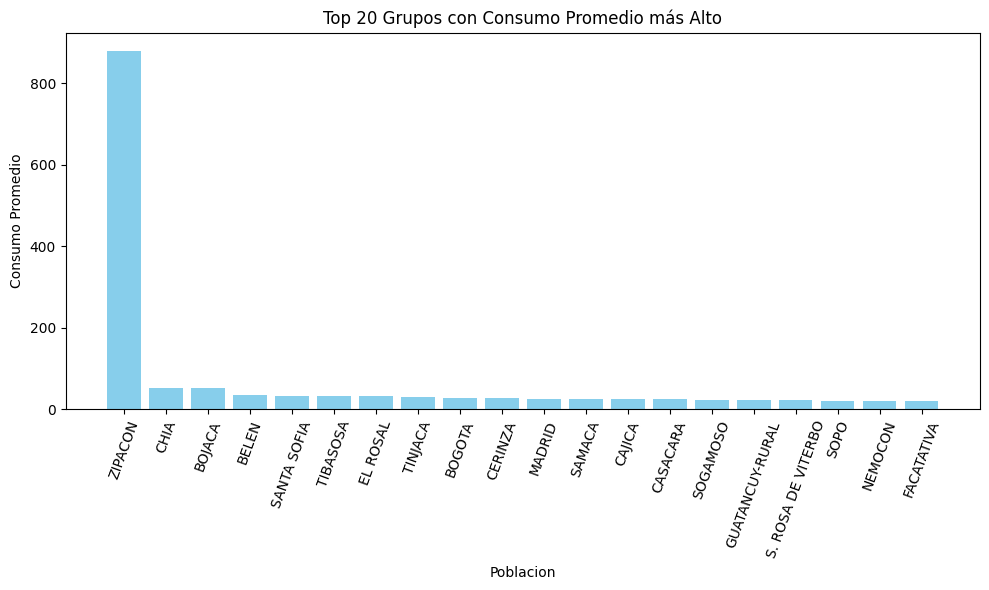

In [ ]:
consumo_promedio_por_grupo = data.groupby('descrip_poblac_suministro')['consumo'].mean()

top_n = 20  # Vamos a seleccionar los top 2 grupos
top_consumos_por_grupo = consumo_promedio_por_grupo.sort_values(ascending=False).head(top_n)

plt.figure(figsize=(10, 6))
plt.bar(top_consumos_por_grupo.index, top_consumos_por_grupo.values, color='skyblue')

plt.title('Top 20 Grupos con Consumo Promedio más Alto')
plt.xlabel('Poblacion')
plt.ylabel('Consumo Promedio')

plt.xticks(rotation=70)
plt.tight_layout()
plt.show()

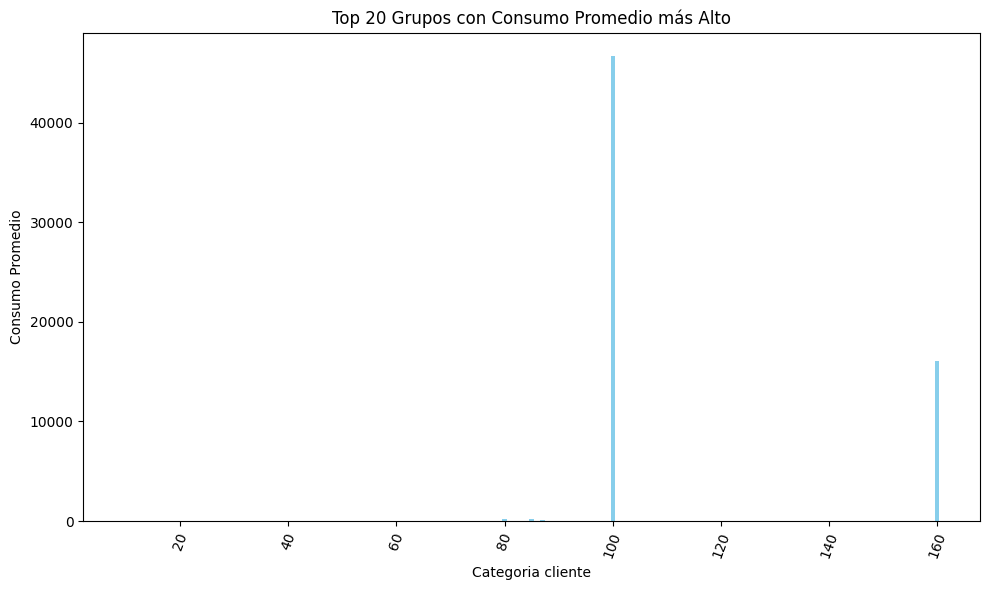

In [ ]:
consumo_promedio_por_grupo = data.groupby('categoria_cliente')['consumo'].mean()

top_n = 20
top_consumos_por_grupo = consumo_promedio_por_grupo.sort_values(ascending=False).head(top_n)

plt.figure(figsize=(10, 6))
plt.bar(top_consumos_por_grupo.index, top_consumos_por_grupo.values, color='skyblue')

plt.title('Top 20 Grupos con Consumo Promedio más Alto')
plt.xlabel('Categoria cliente')
plt.ylabel('Consumo Promedio')

plt.xticks(rotation=70)
plt.tight_layout()
plt.show()

In [ ]:
data[data['categoria_cliente']==100]

,cuenta,fec_contab_documento,consumo,categoria_cliente,porcion,dias_fact,descrip_poblac_suministro
14466,ImFCA9gTqh0TpAnjLFhdvw==,2023-06-09,55667.0,100,P04I,32,BOGOTA
14467,ImFCA9gTqh0TpAnjLFhdvw==,2023-07-13,42883.0,100,P04I,29,BOGOTA
14468,ImFCA9gTqh0TpAnjLFhdvw==,2023-08-14,47898.0,100,P04I,28,BOGOTA
14469,ImFCA9gTqh0TpAnjLFhdvw==,2023-09-07,53904.0,100,P04I,35,BOGOTA
14470,ImFCA9gTqh0TpAnjLFhdvw==,2023-10-17,53436.0,100,P04I,30,BOGOTA
14471,ImFCA9gTqh0TpAnjLFhdvw==,2023-11-14,47652.0,100,P04I,30,BOGOTA
14472,ImFCA9gTqh0TpAnjLFhdvw==,2023-12-13,50790.0,100,P04I,30,BOGOTA
14473,ImFCA9gTqh0TpAnjLFhdvw==,2024-01-16,49347.0,100,P04I,30,BOGOTA
14474,ImFCA9gTqh0TpAnjLFhdvw==,2024-02-15,60061.0,100,P04I,32,BOGOTA
77984,t1kxqD8X5GmgYkZU5VHc8A==,2023-04-17,5348.0,100,NaN,34,BOGOTA


In [ ]:
data[data['categoria_cliente']==160]

,cuenta,fec_contab_documento,consumo,categoria_cliente,porcion,dias_fact,descrip_poblac_suministro
96302,4vXK5PlZF92mOdSVa6Khkg==,2023-06-15,15546.0,160,P01I,31,BOGOTA
96303,4vXK5PlZF92mOdSVa6Khkg==,2023-07-14,15277.0,160,P01I,30,BOGOTA
96304,4vXK5PlZF92mOdSVa6Khkg==,2023-08-15,15243.0,160,P01I,31,BOGOTA
96305,4vXK5PlZF92mOdSVa6Khkg==,2023-09-15,17274.0,160,P01I,31,BOGOTA
96306,4vXK5PlZF92mOdSVa6Khkg==,2023-10-17,15901.0,160,P01I,30,BOGOTA
96307,4vXK5PlZF92mOdSVa6Khkg==,2023-11-16,16151.0,160,P01I,31,BOGOTA
96308,4vXK5PlZF92mOdSVa6Khkg==,2023-12-12,16367.0,160,P01I,30,BOGOTA
96309,4vXK5PlZF92mOdSVa6Khkg==,2024-01-26,16877.0,160,P01I,31,BOGOTA
96310,4vXK5PlZF92mOdSVa6Khkg==,2024-02-21,16098.0,160,P01I,31,BOGOTA


In [ ]:
data[data['descrip_poblac_suministro']=="ZIPACON"]

,cuenta,fec_contab_documento,consumo,categoria_cliente,porcion,dias_fact,descrip_poblac_suministro
49301,dgE8SAn4l8t7EuG40uci4Q==,2023-04-25,935.0,80,P16,31,ZIPACON
49302,dgE8SAn4l8t7EuG40uci4Q==,2023-05-25,767.0,80,P16,27,ZIPACON
49303,dgE8SAn4l8t7EuG40uci4Q==,2023-06-26,987.0,80,P16,32,ZIPACON
49304,dgE8SAn4l8t7EuG40uci4Q==,2023-07-25,856.0,80,P16,28,ZIPACON
49305,dgE8SAn4l8t7EuG40uci4Q==,2023-08-25,826.0,80,P16,28,ZIPACON
49306,dgE8SAn4l8t7EuG40uci4Q==,2023-09-25,892.0,80,P16,31,ZIPACON
49307,dgE8SAn4l8t7EuG40uci4Q==,2023-10-25,865.0,80,P16,31,ZIPACON
49308,dgE8SAn4l8t7EuG40uci4Q==,2023-11-24,855.0,80,P16,30,ZIPACON
49309,dgE8SAn4l8t7EuG40uci4Q==,2023-12-23,839.0,80,P16,28,ZIPACON
49310,dgE8SAn4l8t7EuG40uci4Q==,2024-01-25,977.0,80,P16,31,ZIPACON


In [ ]:
data[data['porcion']=="P04I"]

,cuenta,fec_contab_documento,consumo,categoria_cliente,porcion,dias_fact,descrip_poblac_suministro
14466,ImFCA9gTqh0TpAnjLFhdvw==,2023-06-09,55667.0,100,P04I,32,BOGOTA
14467,ImFCA9gTqh0TpAnjLFhdvw==,2023-07-13,42883.0,100,P04I,29,BOGOTA
14468,ImFCA9gTqh0TpAnjLFhdvw==,2023-08-14,47898.0,100,P04I,28,BOGOTA
14469,ImFCA9gTqh0TpAnjLFhdvw==,2023-09-07,53904.0,100,P04I,35,BOGOTA
14470,ImFCA9gTqh0TpAnjLFhdvw==,2023-10-17,53436.0,100,P04I,30,BOGOTA
14471,ImFCA9gTqh0TpAnjLFhdvw==,2023-11-14,47652.0,100,P04I,30,BOGOTA
14472,ImFCA9gTqh0TpAnjLFhdvw==,2023-12-13,50790.0,100,P04I,30,BOGOTA
14473,ImFCA9gTqh0TpAnjLFhdvw==,2024-01-16,49347.0,100,P04I,30,BOGOTA
14474,ImFCA9gTqh0TpAnjLFhdvw==,2024-02-15,60061.0,100,P04I,32,BOGOTA


In [ ]:
data[data['porcion']=="P01I"]

,cuenta,fec_contab_documento,consumo,categoria_cliente,porcion,dias_fact,descrip_poblac_suministro
96302,4vXK5PlZF92mOdSVa6Khkg==,2023-06-15,15546.0,160,P01I,31,BOGOTA
96303,4vXK5PlZF92mOdSVa6Khkg==,2023-07-14,15277.0,160,P01I,30,BOGOTA
96304,4vXK5PlZF92mOdSVa6Khkg==,2023-08-15,15243.0,160,P01I,31,BOGOTA
96305,4vXK5PlZF92mOdSVa6Khkg==,2023-09-15,17274.0,160,P01I,31,BOGOTA
96306,4vXK5PlZF92mOdSVa6Khkg==,2023-10-17,15901.0,160,P01I,30,BOGOTA
96307,4vXK5PlZF92mOdSVa6Khkg==,2023-11-16,16151.0,160,P01I,31,BOGOTA
96308,4vXK5PlZF92mOdSVa6Khkg==,2023-12-12,16367.0,160,P01I,30,BOGOTA
96309,4vXK5PlZF92mOdSVa6Khkg==,2024-01-26,16877.0,160,P01I,31,BOGOTA
96310,4vXK5PlZF92mOdSVa6Khkg==,2024-02-21,16098.0,160,P01I,31,BOGOTA


In [ ]:
data = data[data['cuenta'] != "ImFCA9gTqh0TpAnjLFhdvw=="] # #Valor de categoría de cliente 100
data = data[data['cuenta'] != "t1kxqD8X5GmgYkZU5VHc8A=="]
data = data[data['cuenta'] != "dgE8SAn4l8t7EuG40uci4Q=="] #Valor de ZIPACON
data = data[data['cuenta'] != "ImFCA9gTqh0TpAnjLFhdvw=="] #Valor de porcion P04I
data = data[data['cuenta'] != "4vXK5PlZF92mOdSVa6Khkg=="] #Valor de porcion P01I

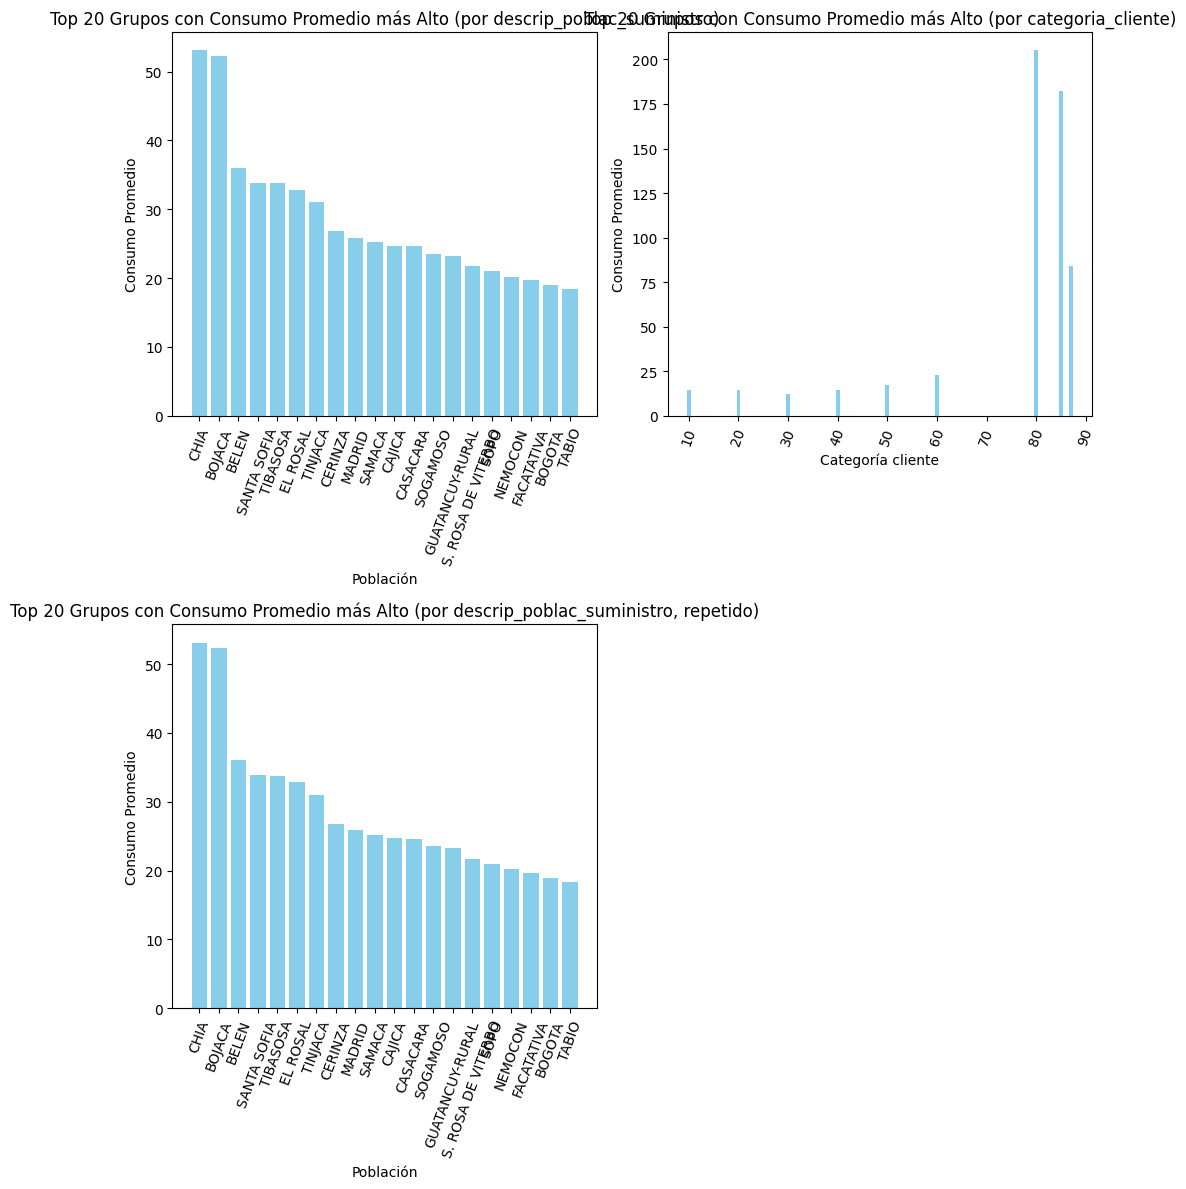

In [ ]:
consumo_promedio_por_grupo = data.groupby('descrip_poblac_suministro')['consumo'].mean()
top_n = 20
top_consumos_por_grupo = consumo_promedio_por_grupo.sort_values(ascending=False).head(top_n)

plt.figure(figsize=(10, 12))

plt.subplot(221)
plt.bar(top_consumos_por_grupo.index, top_consumos_por_grupo.values, color='skyblue')
plt.title('Top 20 Grupos con Consumo Promedio más Alto (por descrip_poblac_suministro)')
plt.xlabel('Población')
plt.ylabel('Consumo Promedio')
plt.xticks(rotation=70)
plt.tight_layout()

consumo_promedio_por_grupo = data.groupby('categoria_cliente')['consumo'].mean()
top_n = 20
top_consumos_por_grupo = consumo_promedio_por_grupo.sort_values(ascending=False).head(top_n)

plt.subplot(222)
plt.bar(top_consumos_por_grupo.index, top_consumos_por_grupo.values, color='skyblue')
plt.title('Top 20 Grupos con Consumo Promedio más Alto (por categoria_cliente)')
plt.xlabel('Categoría cliente')
plt.ylabel('Consumo Promedio')
plt.xticks(rotation=70)
plt.tight_layout()

consumo_promedio_por_grupo = data.groupby('descrip_poblac_suministro')['consumo'].mean()
top_n = 20
top_consumos_por_grupo = consumo_promedio_por_grupo.sort_values(ascending=False).head(top_n)

plt.subplot(223)
plt.bar(top_consumos_por_grupo.index, top_consumos_por_grupo.values, color='skyblue')
plt.title('Top 20 Grupos con Consumo Promedio más Alto (por descrip_poblac_suministro, repetido)')
plt.xlabel('Población')
plt.ylabel('Consumo Promedio')
plt.xticks(rotation=70)
plt.tight_layout()

plt.show()

In [ ]:

contingency_table1 = pd.crosstab(data['descrip_poblac_suministro'], data['porcion'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-cuadrado: {chi2}")
print(f"P-valor: {p}")

Chi-cuadrado: 122162.2704866924
P-valor: 0.0


In [ ]:
contingency_table2 = pd.crosstab(data['categoria_cliente'], data['porcion'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-cuadrado: {chi2}")
print(f"P-valor: {p}")

Chi-cuadrado: 146021.8039490245
P-valor: 0.0


In [ ]:
contingency_table3 = pd.crosstab(data['descrip_poblac_suministro'], data['porcion'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-cuadrado: {chi2}")
print(f"P-valor: {p}")

Chi-cuadrado: 122162.2704866924
P-valor: 0.0


In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table1, annot=True, cmap='coolwarm', cbar=False)
plt.title('Heatmap de Chi-Cuadrado')
plt.xlabel('Porción')
plt.ylabel('Categoría de Cliente')
plt.show()

### Exploración y ajuste de tipos de datos

In [ ]:
data.dtypes

cuenta                        object
fec_contab_documento          object
consumo                      float64
categoria_cliente              int64
porcion                       object
dias_fact                      int64
descrip_poblac_suministro     object
dtype: object

Podemos observar que los tipos de las variables no son los mejores para trabajar el ejercicio por lo que vamos a convertir los tipos de las columnas.

In [ ]:
data['cuenta'] = data['cuenta'].astype('category')
data['fec_contab_documento'] = pd.to_datetime(data['fec_contab_documento']).dt.date #Solo para asegurarnos de que tiene el formato que necesitamos.
data['categoria_cliente'] = data['categoria_cliente'].astype('category')
data['porcion'] = data['porcion'].astype('category')
data['descrip_poblac_suministro'] = data['descrip_poblac_suministro'].astype('category')

In [ ]:
data.dtypes

cuenta                       category
fec_contab_documento           object
consumo                       float64
categoria_cliente            category
porcion                      category
dias_fact                       int64
descrip_poblac_suministro    category
dtype: object

In [ ]:
data.describe()

,consumo,dias_fact
count,108862.000000,108862.000000
mean,18.127534,29.588148
std,68.219053,1.686419
min,0.000000,3.000000
25%,5.000000,29.000000
50%,11.000000,30.000000
75%,19.000000,31.000000
max,3449.000000,67.000000


### Exploración y manejo de valores en null

In [ ]:
data.isnull().sum()

cuenta                          0
fec_contab_documento            0
consumo                         0
categoria_cliente               0
porcion                      7920
dias_fact                       0
descrip_poblac_suministro       0
dtype: int64

Tenemos que el único campo que tiene null es el campo de porcion, por lo que vamos a verificar que sucede con este campo.

In [ ]:
data[data["cuenta"]== "AATHHM6d7TyIT1ubMnB14A=="]

,cuenta,fec_contab_documento,consumo,categoria_cliente,porcion,dias_fact,descrip_poblac_suministro
0,AATHHM6d7TyIT1ubMnB14A==,2023-04-22,0.0,60,P14,33,BOGOTA
1,AATHHM6d7TyIT1ubMnB14A==,2023-05-23,0.0,60,P14,27,BOGOTA
2,AATHHM6d7TyIT1ubMnB14A==,2023-06-23,0.0,60,P14,33,BOGOTA
3,AATHHM6d7TyIT1ubMnB14A==,2023-07-22,0.0,60,P14,27,BOGOTA
4,AATHHM6d7TyIT1ubMnB14A==,2023-08-23,0.0,60,P14,29,BOGOTA
5,AATHHM6d7TyIT1ubMnB14A==,2023-09-23,0.0,60,P14,31,BOGOTA
6,AATHHM6d7TyIT1ubMnB14A==,2023-10-23,0.0,60,P14,29,BOGOTA
7,AATHHM6d7TyIT1ubMnB14A==,2023-11-22,0.0,60,P14,32,BOGOTA
8,AATHHM6d7TyIT1ubMnB14A==,2023-12-21,0.0,60,P14,27,BOGOTA
9,AATHHM6d7TyIT1ubMnB14A==,2024-01-23,0.0,60,P14,30,BOGOTA


En muchos casos vemos que es un faltante dentro de la misma cuenta contrato, por lo que vamos a tomar el riesgo de reemplazar estos datos faltantes por la moda dentro de la misma cuenta contrato.

In [ ]:
mode_by_group = data.groupby('cuenta')['porcion'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)

data['porcion'] = data.apply(lambda row: mode_by_group[row['cuenta']] if pd.isnull(row['porcion']) else row['porcion'], axis=1)

In [ ]:
data[data["cuenta"]== "AATHHM6d7TyIT1ubMnB14A=="]

,cuenta,fec_contab_documento,consumo,categoria_cliente,porcion,dias_fact,descrip_poblac_suministro
0,AATHHM6d7TyIT1ubMnB14A==,2023-04-22,0.0,60,P14,33,BOGOTA
1,AATHHM6d7TyIT1ubMnB14A==,2023-05-23,0.0,60,P14,27,BOGOTA
2,AATHHM6d7TyIT1ubMnB14A==,2023-06-23,0.0,60,P14,33,BOGOTA
3,AATHHM6d7TyIT1ubMnB14A==,2023-07-22,0.0,60,P14,27,BOGOTA
4,AATHHM6d7TyIT1ubMnB14A==,2023-08-23,0.0,60,P14,29,BOGOTA
5,AATHHM6d7TyIT1ubMnB14A==,2023-09-23,0.0,60,P14,31,BOGOTA
6,AATHHM6d7TyIT1ubMnB14A==,2023-10-23,0.0,60,P14,29,BOGOTA
7,AATHHM6d7TyIT1ubMnB14A==,2023-11-22,0.0,60,P14,32,BOGOTA
8,AATHHM6d7TyIT1ubMnB14A==,2023-12-21,0.0,60,P14,27,BOGOTA
9,AATHHM6d7TyIT1ubMnB14A==,2024-01-23,0.0,60,P14,30,BOGOTA


In [ ]:
data.isnull().sum()

cuenta                        0
fec_contab_documento          0
consumo                       0
categoria_cliente             0
porcion                      57
dias_fact                     0
descrip_poblac_suministro     0
dtype: int64

Podemos observar como pasamos de 7922 null a solo 58 null en porcion.

### Exploración y manejo de outliers

#### Número de consumos por cuentas

In [ ]:
data.describe()

,consumo,dias_fact
count,108862.000000,108862.000000
mean,18.127534,29.588148
std,68.219053,1.686419
min,0.000000,3.000000
25%,5.000000,29.000000
50%,11.000000,30.000000
75%,19.000000,31.000000
max,3449.000000,67.000000


Contamos con 8000 cuentas únicas.

In [ ]:
data["cuenta"].nunique()

7996

Muchas de estas cuentas parece que solo tienen unos cuantos registros.

In [ ]:
conteo_valores = data['cuenta'].value_counts()
conteo_valores = conteo_valores[conteo_valores < 14].copy()
conteo_valores

cuenta
j+mC9QBJju3v1Ivljqfqqg==    13
u4LRhpLpoGr2yhMrmTOU2Q==    13
IrWPsFSZZY6qgBY73xrc9Q==    13
h/9N0bjljXPjAO1V4HnNjg==    13
chMUJTmppwdyI6MnfYX5FQ==    13
                            ..
DuOKa0q3AV50vfPT19Uz5A==     1
Z3zjN8vXT3w9KJQO+BvgRg==     1
+rZ87A0R/v7KyWj/eq+RWQ==     1
RdJc1XEurShXsGdTwA2sdw==     1
Dya3sR0F9B11tHsmo7xsRA==     1
Name: count, Length: 423, dtype: int64

Quitaremos las cuentas que tienen menos de 14 registros para tener un estándar en nuestras mediciones posteriores.

In [ ]:
ccd = conteo_valores.reset_index()
ccd.columns = ['cuenta', 'valor']
ccd.drop(columns = ["valor"])

,cuenta
0,j+mC9QBJju3v1Ivljqfqqg==
1,u4LRhpLpoGr2yhMrmTOU2Q==
2,IrWPsFSZZY6qgBY73xrc9Q==
3,h/9N0bjljXPjAO1V4HnNjg==
4,chMUJTmppwdyI6MnfYX5FQ==
...,...
418,DuOKa0q3AV50vfPT19Uz5A==
419,Z3zjN8vXT3w9KJQO+BvgRg==
420,+rZ87A0R/v7KyWj/eq+RWQ==
421,RdJc1XEurShXsGdTwA2sdw==


In [ ]:
data_14 = data[~data["cuenta"].isin(ccd["cuenta"])].copy()

In [ ]:
data_14 = data_14.reset_index(drop=True)

In [ ]:
data_14

,cuenta,fec_contab_documento,consumo,categoria_cliente,porcion,dias_fact,descrip_poblac_suministro
0,AATHHM6d7TyIT1ubMnB14A==,2023-04-22,0.0,60,P14,33,BOGOTA
1,AATHHM6d7TyIT1ubMnB14A==,2023-05-23,0.0,60,P14,27,BOGOTA
2,AATHHM6d7TyIT1ubMnB14A==,2023-06-23,0.0,60,P14,33,BOGOTA
3,AATHHM6d7TyIT1ubMnB14A==,2023-07-22,0.0,60,P14,27,BOGOTA
4,AATHHM6d7TyIT1ubMnB14A==,2023-08-23,0.0,60,P14,29,BOGOTA
...,...,...,...,...,...,...,...
106017,//zeLQj06uUX0jXMTus/VA==,2024-01-09,15.0,20,P03,30,BOGOTA
106018,//zeLQj06uUX0jXMTus/VA==,2024-02-07,15.0,20,P03,29,BOGOTA
106019,//zeLQj06uUX0jXMTus/VA==,2024-03-06,15.0,20,P03,29,BOGOTA
106020,//zeLQj06uUX0jXMTus/VA==,2024-04-05,15.0,20,P03,30,BOGOTA


In [ ]:
data_14[data_14["cuenta"]=="ET7fwSqwjTzjFcZ/XBRbdw=="]

,cuenta,fec_contab_documento,consumo,categoria_cliente,porcion,dias_fact,descrip_poblac_suministro


In [ ]:
print(data_14.count())
print(data.count())

cuenta                       106022
fec_contab_documento         106022
consumo                      106022
categoria_cliente            106022
porcion                      106022
dias_fact                    106022
descrip_poblac_suministro    106022
dtype: int64
cuenta                       108862
fec_contab_documento         108862
consumo                      108862
categoria_cliente            108862
porcion                      108805
dias_fact                    108862
descrip_poblac_suministro    108862
dtype: int64


In [ ]:
conteo_valores1 = data_14['cuenta'].value_counts()

conteo_valores1 = conteo_valores1[conteo_valores1 < 14]
indices_numericos = conteo_valores1.index
indices_numericos = conteo_valores1.index.tolist()
print(indices_numericos)


['HrO/VQ6qo9sMISyrdS4itw==', 'rJrDNxZIgykPT3g3cFVQBw==', 'eeCEP83cdNNtSpRXIiuyrA==', 'STB7cWTQR1LzFOLQKBNPCA==', '9kDC1LEdtioH6pL7NJ8mPg==', 'RyC3MHR3arkrFZL3suKuOQ==', '6K+6Yh+bpSeO63JeZdT2Mw==', '31iTMAGTD7gFWiZ4azmwuQ==', 'chMUJTmppwdyI6MnfYX5FQ==', 'v1QF3gSzlcma6sWgbtrPmQ==', 'chpYEwPGUPc9flXev/EDfg==', 'cqN5n9ns0ZpTalshq7VNsg==', 'UiH9hO3XP2MinUZbDG2KVw==', 'KCdBIGs3gqY6SE5qoTeGVg==', 'V5ZQ8CV+4g2igyHmtOcwYA==', 'fWIK7DPWtXrrOjFWkJeyAg==', 'ys+BvGeWR2fbRT1MXQCtsQ==', 'iEIQh0fc7CFkn8w1GBxxxg==', 'b/2bI7u6nmA2OYDSNJ7CEQ==', 'ZFUJJhTWUdzYVDCxqZlm6Q==', 'VBd5GrQiyTgwOgUb07goKQ==', 'fVAuxoQTYdhHPy1MR23t8A==', 'rG5433h0+FfgLR7MP6Y8pQ==', 'fGfz93Sm+92nom4SrFmwoQ==', '/0YkmcAGBPSKE1SoNhNLyg==', 'FGFib5r2IpT7cVd/nlGf1Q==', '36JRKYdsFH9Ax41bOR38yg==', '810luFD+4GX59nO4URcXUQ==', 'VBR3bKb0fwwY7N+J6hqHMg==', 'ZFitaCSVPf2bXEeWs160Tg==', 'S8E5Teh6FMJ/NTYXYtwXFA==', 'nw1CEZRzyZMhmm7xRNbrGA==', '30RenbsQ4rxpG9TrXzXnBg==', 'yEojsWvpOEIFFNVRs97b5A==', 'UojzC9K87gz+At4f+4kAhg==', 'rYAsmijJJ9fWdLmWiA

Verificamos que se hayan eliminado los registros que no necesitamos.

In [ ]:
data[data["cuenta"]=="Jccc9/ER/rhF7NsZY3RbtQ=="]

,cuenta,fec_contab_documento,consumo,categoria_cliente,porcion,dias_fact,descrip_poblac_suministro
16277,Jccc9/ER/rhF7NsZY3RbtQ==,2024-03-14,12.0,20,P10,16,OICATA
16278,Jccc9/ER/rhF7NsZY3RbtQ==,2024-04-16,14.0,20,P10,28,OICATA
16279,Jccc9/ER/rhF7NsZY3RbtQ==,2024-05-17,11.0,20,P10,32,OICATA


In [ ]:
data_14[data_14["cuenta"]=="Jccc9/ER/rhF7NsZY3RbtQ=="]

,cuenta,fec_contab_documento,consumo,categoria_cliente,porcion,dias_fact,descrip_poblac_suministro


Tenemos 426 cuentas que tienen menos de 14 registros, un 5% del total de las cuentas que representan 2859 registros un 2.63% del total de los registros. Lo cuál nos confirma que teníamos muchas cuentas con muy pocos periodos para poder proyectar.

In [ ]:
print("Número de cuentas únicas con 14 consumos: ", data_14["cuenta"].nunique())
print("Número de registros en la base con la restricción de 14 consumos por cuenta: ", data_14["cuenta"].count())

Número de cuentas únicas con 14 consumos:  7573
Número de registros en la base con la restricción de 14 consumos por cuenta:  106022


#### Días facturados

Vemos que el promedio de días de facturación es de 29.6 días, el mínimo es de 3 días y el máximo es de 67 días, vamos a explorar si esto es normal dentro de las mismas cuentas o por el contrario estas mediciones son anormales.

In [ ]:
data_14.describe()

,consumo,dias_fact
count,106022.000000,106022.000000
mean,18.282281,29.607440
std,68.901386,1.587061
min,0.000000,7.000000
25%,5.000000,29.000000
50%,11.000000,30.000000
75%,19.000000,31.000000
max,3449.000000,36.000000


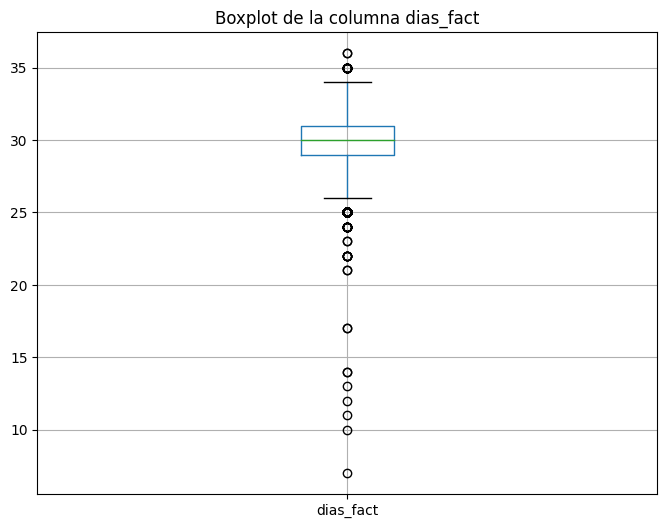

In [ ]:
plt.figure(figsize=(8, 6))
data_14.boxplot(column='dias_fact')
plt.title('Boxplot de la columna dias_fact')
plt.show()

In [ ]:
ip1 = data_14.groupby('cuenta')['dias_fact'].transform(lambda x: x.quantile(0.1))
ip3 = data_14.groupby('cuenta')['dias_fact'].transform(lambda x: x.quantile(0.9))
iip = ip3 - ip1

Escogimos un rango interpercentil y no intercuartilico debido a que como lo observamos en el descriptivo anterior el percentil 25 sacaba días de facturación menores a 29 que no va acorde a lo que en el negocio puede presentarse, que pueden ser facturaciones a 25 días o a 32 días.

In [ ]:
limite_superior = ip3 + 1.5 * iip
limite_inferior = ip1 - 1.5 * iip

data_14['limite_superior'] = limite_superior
data_14['limite_inferior'] = limite_inferior

Tenemos muy pocas cuentas con más de un valor considerado outlayer, pero al analizar más estas cuentas, no parecen ser valores que para este ejercicio nos afecte demasiado, revisaremos con el consumo para comprobar si esto nos afecta o no.

In [ ]:
data_14['es_outlier'] = (data_14['dias_fact'] > data_14['limite_superior']) | (data_14['dias_fact'] < data_14['limite_inferior'])
data_14[data_14['es_outlier']==True].sort_values(by="cuenta")
print("Número de cuentas únicas con valores considerados outlayers: ",data_14["cuenta"][data_14['es_outlier']==True].nunique())
print("Número de registros con valores considerados outlayers: ", data_14["cuenta"][data_14['es_outlier']==True].count())

Número de cuentas únicas con valores considerados outlayers:  36
Número de registros con valores considerados outlayers:  42


Podemos identificar que aunque tenemos outliers, estos se presentan muy poco por cada cuenta y los valores se encuentran dentro de las días de facturación normales, el gráfico de caja y bigotes y el QQ nos muestra días bastante extraños, podríamos separar estos casos para entrar a revisar con negocio que sucede, se puede suponer un problema para acceder a la zona. Por el momento para abordar esta situación vamos a tratar estos outliers de días de facturación normalizando el consumo a 30 días.

In [ ]:
outliers_dias_fact = data_14[data_14['es_outlier']==True].sort_values(by="cuenta")
outliers_dias_fact = outliers_dias_fact[outliers_dias_fact["cuenta"].duplicated(keep=False)]
outliers_dias_fact

,cuenta,fec_contab_documento,consumo,categoria_cliente,porcion,dias_fact,descrip_poblac_suministro,limite_superior,limite_inferior,es_outlier
695,AjSoEynPx6GlFhRYix/6PA==,2024-01-04,25.0,60,P01,32,BOGOTA,31.5,27.5,True
697,AjSoEynPx6GlFhRYix/6PA==,2024-03-04,21.0,60,P01,27,BOGOTA,31.5,27.5,True
36311,WZMDWPWU6sFY8H1Hg0Yo6Q==,2024-01-04,9.0,60,P01,32,BOGOTA,31.5,27.5,True
36313,WZMDWPWU6sFY8H1Hg0Yo6Q==,2024-03-04,6.0,60,P01,27,BOGOTA,31.5,27.5,True
36593,WjXYgTiQ4bVgpSQ+Yhjh6Q==,2024-03-05,13.0,40,P01,27,PIEDECUESTA,31.5,27.5,True
36591,WjXYgTiQ4bVgpSQ+Yhjh6Q==,2024-01-04,17.0,40,P01,32,PIEDECUESTA,31.5,27.5,True
47833,dUrLs46bZg9EB7w0vvr+Mw==,2024-01-04,22.0,60,P01,32,BOGOTA,31.5,27.5,True
47835,dUrLs46bZg9EB7w0vvr+Mw==,2024-03-04,28.0,60,P01,27,BOGOTA,31.5,27.5,True
52539,gNbnWpJf4g9HKQezY9g6Vg==,2024-03-05,7.0,30,P01,27,BUCARAMANGA,31.5,27.5,True
52537,gNbnWpJf4g9HKQezY9g6Vg==,2024-01-04,2.0,30,P01,32,BUCARAMANGA,31.5,27.5,True


In [ ]:
data_14[data_14["cuenta"] == "uKYtHG1lTdpYZoK0W8STrg=="]

,cuenta,fec_contab_documento,consumo,categoria_cliente,porcion,dias_fact,descrip_poblac_suministro,limite_superior,limite_inferior,es_outlier
76440,uKYtHG1lTdpYZoK0W8STrg==,2023-04-04,51.0,60,P01,30,BOGOTA,31.5,27.5,False
76441,uKYtHG1lTdpYZoK0W8STrg==,2023-05-05,46.0,60,P01,30,BOGOTA,31.5,27.5,False
76442,uKYtHG1lTdpYZoK0W8STrg==,2023-06-05,45.0,60,P01,29,BOGOTA,31.5,27.5,False
76443,uKYtHG1lTdpYZoK0W8STrg==,2023-07-06,39.0,60,P01,29,BOGOTA,31.5,27.5,False
76444,uKYtHG1lTdpYZoK0W8STrg==,2023-08-03,22.0,60,P01,30,BOGOTA,31.5,27.5,False
76445,uKYtHG1lTdpYZoK0W8STrg==,2023-09-06,48.0,60,P01,30,BOGOTA,31.5,27.5,False
76446,uKYtHG1lTdpYZoK0W8STrg==,2023-10-04,47.0,60,P01,30,BOGOTA,31.5,27.5,False
76447,uKYtHG1lTdpYZoK0W8STrg==,2023-11-03,45.0,60,P01,29,BOGOTA,31.5,27.5,False
76448,uKYtHG1lTdpYZoK0W8STrg==,2023-12-05,44.0,60,P01,29,BOGOTA,31.5,27.5,False
76449,uKYtHG1lTdpYZoK0W8STrg==,2024-01-04,43.0,60,P01,32,BOGOTA,31.5,27.5,True


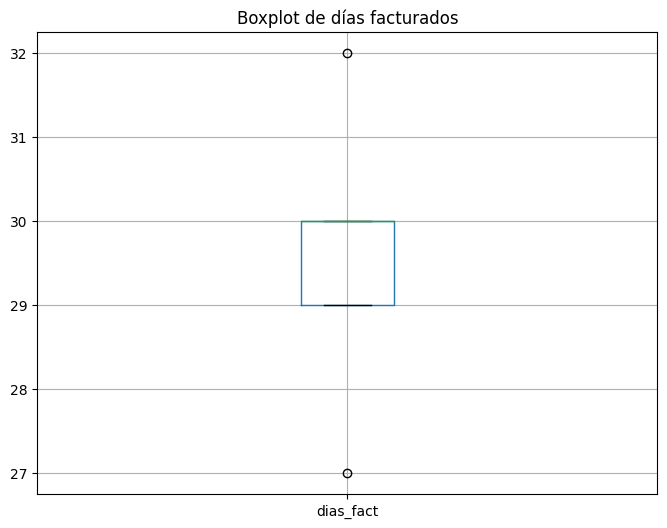

In [ ]:
ejemplo = data_14[data_14["cuenta"] == "uKYtHG1lTdpYZoK0W8STrg=="]
plt.figure(figsize=(8, 6))
ejemplo.boxplot(column='dias_fact')
plt.title('Boxplot de días facturados')
plt.show()

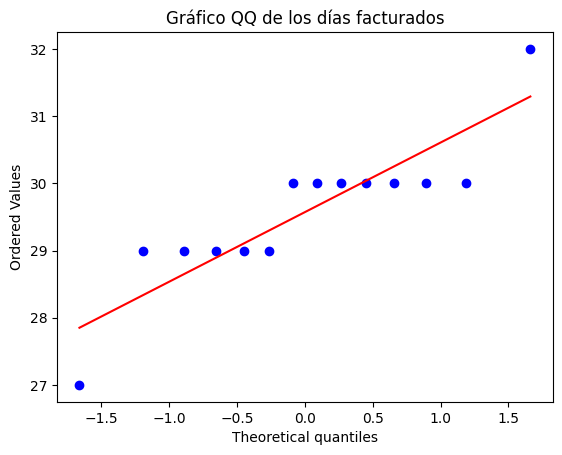

In [ ]:
data_subconjunto = data_14[data_14["cuenta"] == "uKYtHG1lTdpYZoK0W8STrg=="]["dias_fact"]

stats.probplot(data_subconjunto, dist="norm", plot=plt)
plt.title("Gráfico QQ de los días facturados")
plt.show()

In [ ]:
data_14["consumo_normalizado"] = (data_14["consumo"]/data_14["dias_fact"])*30

#### Consumo

Normalizamos el consumo acorde a los días facturados del cliente, con esto ya estandarizado y descartando los problemas que observamos con los días facturados procedemos ahora a revisar que outliers tenemos en el consumo y si están relacionados con los días facturados.

In [ ]:
data_14 = data_14.drop(columns=["limite_superior","limite_inferior","es_outlier"])

In [ ]:
data_14.describe()

,consumo,dias_fact,consumo_normalizado
count,106022.000000,106022.000000,106022.000000
mean,18.282281,29.607440,18.544257
std,68.901386,1.587061,69.832277
min,0.000000,7.000000,0.000000
25%,5.000000,29.000000,5.172414
50%,11.000000,30.000000,11.612903
75%,19.000000,31.000000,19.655172
max,3449.000000,36.000000,3164.000000


Aún normalizando el consumo vemos consumos bastante altos, por lo que vamos a explorar estos consumos dentro de la misma cuenta contrato para entender si estos consumos son anormales o no.

In [ ]:
media_consumo = data_14.groupby('cuenta')['consumo_normalizado'].transform('mean')
std_consumo = data_14.groupby('cuenta')['consumo_normalizado'].transform('std')

limite_superior_consumo = media_consumo + 3 * std_consumo
limite_inferior_consumo = media_consumo - 3 * std_consumo

Para el caso del consumo vamos a utilizar 3 desviaciones estándar por encima y por debajo de la media.

In [ ]:
outliers = data_14[(data_14['consumo_normalizado'] > limite_superior_consumo) | (data_14['consumo_normalizado'] < limite_inferior_consumo)]

print("Outliers identificados:")
print(outliers["cuenta"].count())

Outliers identificados:
254


Nos encontramos con solo 254 cuentas que se pueden identificar como Outliers, a pesar de que encontramos valores muy altos en consumo.

In [ ]:
outliers.head(5)

,cuenta,fec_contab_documento,consumo,categoria_cliente,porcion,dias_fact,descrip_poblac_suministro,consumo_normalizado
1008,AxSQAUrQZ0/gP0QU08w+qQ==,2023-04-27,13.0,20,P18,32,BOGOTA,12.187500
1095,A0fnK54PKrVhjH9tREXfZg==,2023-07-14,2.0,30,P08,29,BOGOTA,2.068966
1442,BAVQTZQenwEq47ruOvtwVQ==,2023-04-05,21.0,10,P02,31,BOGOTA,20.322581
1968,BSQjxjrxGzzx0tkvW1saMA==,2023-12-18,1.0,30,P11,28,BARRANCABERMEJA,1.071429
2098,BXihgYqmss7ygzqKIYCyyw==,2024-04-18,1.0,80,P12,29,NOBSA,1.034483


In [ ]:
data_14[data_14["cuenta"] == "AxSQAUrQZ0/gP0QU08w+qQ=="]

,cuenta,fec_contab_documento,consumo,categoria_cliente,porcion,dias_fact,descrip_poblac_suministro,consumo_normalizado
1008,AxSQAUrQZ0/gP0QU08w+qQ==,2023-04-27,13.0,20,P18,32,BOGOTA,12.1875
1009,AxSQAUrQZ0/gP0QU08w+qQ==,2023-05-29,0.0,20,P18,27,BOGOTA,0.0000
1010,AxSQAUrQZ0/gP0QU08w+qQ==,2023-06-28,0.0,20,P18,29,BOGOTA,0.0000
1011,AxSQAUrQZ0/gP0QU08w+qQ==,2023-07-27,0.0,20,P18,30,BOGOTA,0.0000
1012,AxSQAUrQZ0/gP0QU08w+qQ==,2023-08-29,0.0,20,P18,30,BOGOTA,0.0000
1013,AxSQAUrQZ0/gP0QU08w+qQ==,2023-09-27,0.0,20,P18,28,BOGOTA,0.0000
1014,AxSQAUrQZ0/gP0QU08w+qQ==,2023-10-27,0.0,20,P18,31,BOGOTA,0.0000
1015,AxSQAUrQZ0/gP0QU08w+qQ==,2023-11-29,0.0,20,P18,30,BOGOTA,0.0000
1016,AxSQAUrQZ0/gP0QU08w+qQ==,2023-12-27,0.0,20,P18,28,BOGOTA,0.0000
1017,AxSQAUrQZ0/gP0QU08w+qQ==,2024-01-29,0.0,20,P18,31,BOGOTA,0.0000


Aquí podemos observar que aunque el consumo es bastante alto dentro de todos los consumos, dentro de sus propios consumos este es un consumo normal.

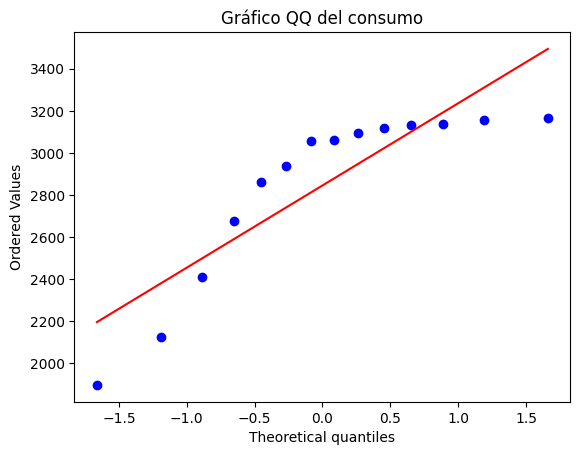

In [ ]:
data_subconjunto = data_14[data_14["cuenta"] == "PRCaqrA6l7ZjuCSZbf9Q/w=="]["consumo_normalizado"]

stats.probplot(data_subconjunto, dist="norm", plot=plt)
plt.title("Gráfico QQ del consumo")
plt.show()

Aún así nuestra gráfica QQ nos muestra que estos consumos tienen un comportamiento algo erratico, pero contamos con muy pocos casos como para confirmarlo.

In [ ]:
data_filtrado = data_14[~data_14["cuenta"].isin(outliers["cuenta"])]
data_filtrado = data_filtrado.reset_index(drop=True)

In [ ]:
data_filtrado.describe()

,consumo,dias_fact,consumo_normalizado
count,102466.000000,102466.000000,102466.000000
mean,18.567203,29.607948,18.832983
std,69.801620,1.584752,70.745516
min,0.000000,10.000000,0.000000
25%,5.000000,29.000000,5.357143
50%,12.000000,30.000000,11.785714
75%,19.000000,31.000000,19.655172
max,3449.000000,36.000000,3164.000000


In [ ]:
data_filtrado.head(2)

,cuenta,fec_contab_documento,consumo,categoria_cliente,porcion,dias_fact,descrip_poblac_suministro,consumo_normalizado
0,AATHHM6d7TyIT1ubMnB14A==,2023-04-22,0.0,60,P14,33,BOGOTA,0.0
1,AATHHM6d7TyIT1ubMnB14A==,2023-05-23,0.0,60,P14,27,BOGOTA,0.0


#### Prueba de shapiro Wilks

In [ ]:
cuentas_con_14_registros = data_filtrado['cuenta'].value_counts()[data_filtrado['cuenta'].value_counts() == 14].index

resultados = []
alpha = 0.05

for cuenta in cuentas_con_14_registros:
    consumo_grupo = data_filtrado.loc[data_filtrado['cuenta'] == cuenta, 'consumo_normalizado'].values
    statistic, p_value = stats.shapiro(consumo_grupo)
    es_normal = True if p_value > alpha else False
    resultados.append((cuenta, p_value, es_normal))

resultados_df = pd.DataFrame(resultados, columns=['cuenta', 'p_value', 'es_normal'])
data_filtrado = pd.merge(data_filtrado, resultados_df, on='cuenta', how='left')

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


In [ ]:
data_filtrado[data_filtrado['es_normal']== False]

,cuenta,fec_contab_documento,consumo,categoria_cliente,porcion,dias_fact,descrip_poblac_suministro,consumo_normalizado,p_value,es_normal
56,ADxBNcbMPdb7/k2M99o59g==,2023-04-13,0.0,20,P06,33,BOGOTA,0.000000,0.000013,False
57,ADxBNcbMPdb7/k2M99o59g==,2023-05-12,1.0,20,P06,27,BOGOTA,1.111111,0.000013,False
58,ADxBNcbMPdb7/k2M99o59g==,2023-06-14,0.0,20,P06,29,BOGOTA,0.000000,0.000013,False
59,ADxBNcbMPdb7/k2M99o59g==,2023-07-12,0.0,20,P06,30,BOGOTA,0.000000,0.000013,False
60,ADxBNcbMPdb7/k2M99o59g==,2023-08-11,0.0,20,P06,30,BOGOTA,0.000000,0.000013,False
...,...,...,...,...,...,...,...,...,...,...
102405,//QoG364E3dB9P6/VUc6cg==,2024-01-15,0.0,20,P07,29,BARRANCABERMEJA,0.000000,0.011237,False
102406,//QoG364E3dB9P6/VUc6cg==,2024-02-12,0.0,20,P07,28,BARRANCABERMEJA,0.000000,0.011237,False
102407,//QoG364E3dB9P6/VUc6cg==,2024-03-11,6.0,20,P07,28,BARRANCABERMEJA,6.428571,0.011237,False
102408,//QoG364E3dB9P6/VUc6cg==,2024-04-11,9.0,20,P07,30,BARRANCABERMEJA,9.000000,0.011237,False


In [ ]:
data_filtrado[data_filtrado["cuenta"] == "ADxBNcbMPdb7/k2M99o59g=="]

,cuenta,fec_contab_documento,consumo,categoria_cliente,porcion,dias_fact,descrip_poblac_suministro,consumo_normalizado,p_value,es_normal
56,ADxBNcbMPdb7/k2M99o59g==,2023-04-13,0.0,20,P06,33,BOGOTA,0.000000,0.000013,False
57,ADxBNcbMPdb7/k2M99o59g==,2023-05-12,1.0,20,P06,27,BOGOTA,1.111111,0.000013,False
58,ADxBNcbMPdb7/k2M99o59g==,2023-06-14,0.0,20,P06,29,BOGOTA,0.000000,0.000013,False
59,ADxBNcbMPdb7/k2M99o59g==,2023-07-12,0.0,20,P06,30,BOGOTA,0.000000,0.000013,False
60,ADxBNcbMPdb7/k2M99o59g==,2023-08-11,0.0,20,P06,30,BOGOTA,0.000000,0.000013,False
61,ADxBNcbMPdb7/k2M99o59g==,2023-09-12,0.0,20,P06,29,BOGOTA,0.000000,0.000013,False
62,ADxBNcbMPdb7/k2M99o59g==,2023-10-11,0.0,20,P06,29,BOGOTA,0.000000,0.000013,False
63,ADxBNcbMPdb7/k2M99o59g==,2023-11-11,0.0,20,P06,31,BOGOTA,0.000000,0.000013,False
64,ADxBNcbMPdb7/k2M99o59g==,2023-12-11,2.0,20,P06,30,BOGOTA,2.000000,0.000013,False
65,ADxBNcbMPdb7/k2M99o59g==,2024-01-12,0.0,20,P06,31,BOGOTA,0.000000,0.000013,False


In [ ]:
true_values = data_filtrado[data_filtrado['es_normal'] == True]
percentage_true = len(true_values) / len(data_filtrado) * 100
percentage_true

73.24771143598852

Identificamos que tenemos un 73.25 % de cuentas contrato que tienen un comportamiento normal, por lo que vamos a normalizar la data para nuestros modelos. (Para que estos puedan cumplir con el principio de media 0, desviación estándar 1)

In [ ]:
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data_filtrado[['consumo_normalizado']])

In [ ]:
data_normalized

array([[0.        ],
       [0.        ],
       [0.        ],
       ...,
       [0.00490431],
       [0.00474083],
       [0.00392345]])

In [ ]:
data_filtrado["consumo_normalizado_norm"] = data_normalized

In [ ]:
data_filtrado

,cuenta,fec_contab_documento,consumo,categoria_cliente,porcion,dias_fact,descrip_poblac_suministro,consumo_normalizado,p_value,es_normal,consumo_normalizado_norm
0,AATHHM6d7TyIT1ubMnB14A==,2023-04-22,0.0,60,P14,33,BOGOTA,0.000000,1.00000,True,0.000000
1,AATHHM6d7TyIT1ubMnB14A==,2023-05-23,0.0,60,P14,27,BOGOTA,0.000000,1.00000,True,0.000000
2,AATHHM6d7TyIT1ubMnB14A==,2023-06-23,0.0,60,P14,33,BOGOTA,0.000000,1.00000,True,0.000000
3,AATHHM6d7TyIT1ubMnB14A==,2023-07-22,0.0,60,P14,27,BOGOTA,0.000000,1.00000,True,0.000000
4,AATHHM6d7TyIT1ubMnB14A==,2023-08-23,0.0,60,P14,29,BOGOTA,0.000000,1.00000,True,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
102461,//zeLQj06uUX0jXMTus/VA==,2024-01-09,15.0,20,P03,30,BOGOTA,15.000000,0.23061,True,0.004741
102462,//zeLQj06uUX0jXMTus/VA==,2024-02-07,15.0,20,P03,29,BOGOTA,15.517241,0.23061,True,0.004904
102463,//zeLQj06uUX0jXMTus/VA==,2024-03-06,15.0,20,P03,29,BOGOTA,15.517241,0.23061,True,0.004904
102464,//zeLQj06uUX0jXMTus/VA==,2024-04-05,15.0,20,P03,30,BOGOTA,15.000000,0.23061,True,0.004741


In [ ]:
data_filtrado = data_filtrado.drop(columns=["consumo","dias_fact","p_value","es_normal"])

In [ ]:
data_filtrado

,cuenta,fec_contab_documento,categoria_cliente,porcion,descrip_poblac_suministro,consumo_normalizado,consumo_normalizado_norm
0,AATHHM6d7TyIT1ubMnB14A==,2023-04-22,60,P14,BOGOTA,0.000000,0.000000
1,AATHHM6d7TyIT1ubMnB14A==,2023-05-23,60,P14,BOGOTA,0.000000,0.000000
2,AATHHM6d7TyIT1ubMnB14A==,2023-06-23,60,P14,BOGOTA,0.000000,0.000000
3,AATHHM6d7TyIT1ubMnB14A==,2023-07-22,60,P14,BOGOTA,0.000000,0.000000
4,AATHHM6d7TyIT1ubMnB14A==,2023-08-23,60,P14,BOGOTA,0.000000,0.000000
...,...,...,...,...,...,...,...
102461,//zeLQj06uUX0jXMTus/VA==,2024-01-09,20,P03,BOGOTA,15.000000,0.004741
102462,//zeLQj06uUX0jXMTus/VA==,2024-02-07,20,P03,BOGOTA,15.517241,0.004904
102463,//zeLQj06uUX0jXMTus/VA==,2024-03-06,20,P03,BOGOTA,15.517241,0.004904
102464,//zeLQj06uUX0jXMTus/VA==,2024-04-05,20,P03,BOGOTA,15.000000,0.004741


### Modelado

In [ ]:
data_filtrado = data_filtrado.sort_values(by=['cuenta', 'fec_contab_documento'], ascending=[True, True])

Primero que nada eliminamos las cuentas que tienen solo 0.

In [ ]:
cuentas_a_eliminar = data_filtrado.groupby('cuenta').filter(lambda x: (x['consumo_normalizado'] == 0).all())

data_filtrado = data_filtrado[~data_filtrado['cuenta'].isin(cuentas_a_eliminar['cuenta'])]

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
data_filtrado['poblacion']=LabelEncoder().fit_transform(data_filtrado['descrip_poblac_suministro'])
data_filtrado['porcion']=LabelEncoder().fit_transform(data_filtrado['porcion'])
data_filtrado['categoria']=LabelEncoder().fit_transform(data_filtrado['categoria_cliente'])
data_filtrado['fecha'] = pd.to_datetime(data_filtrado['fec_contab_documento'])
data_filtrado['anio'] = data_filtrado['fecha'].dt.year
data_filtrado['mes'] = data_filtrado['fecha'].dt.month

<ipython-input-74-2c6e1b1b1a2f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtrado['poblacion']=LabelEncoder().fit_transform(data_filtrado['descrip_poblac_suministro'])
<ipython-input-74-2c6e1b1b1a2f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtrado['porcion']=LabelEncoder().fit_transform(data_filtrado['porcion'])
<ipython-input-74-2c6e1b1b1a2f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [ ]:
data_filtrado.drop(columns=["fec_contab_documento","descrip_poblac_suministro","porcion","categoria_cliente"],inplace=True)

<ipython-input-75-cd563537e200>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtrado.drop(columns=["fec_contab_documento","descrip_poblac_suministro","porcion","categoria_cliente"],inplace=True)


In [ ]:
data_filtrado.head(5)

,cuenta,consumo_normalizado,consumo_normalizado_norm,poblacion,categoria,fecha,anio,mes
100716,++DvjLrznHnG8Tj0Hao1AQ==,6.562500,0.002074,8,1,2023-04-05,2023,4
100717,++DvjLrznHnG8Tj0Hao1AQ==,7.241379,0.002289,8,1,2023-05-09,2023,5
100718,++DvjLrznHnG8Tj0Hao1AQ==,5.357143,0.001693,8,1,2023-06-06,2023,6
100719,++DvjLrznHnG8Tj0Hao1AQ==,7.741935,0.002447,8,1,2023-07-07,2023,7
100720,++DvjLrznHnG8Tj0Hao1AQ==,2.142857,0.000677,8,1,2023-08-04,2023,8


In [ ]:
df = data_filtrado
df['fecha'] = pd.to_datetime(df['fecha'])

features = ['anio', 'mes', 'poblacion', 'categoria']
target = 'consumo_normalizado'

numeric_features = ['anio', 'poblacion']
categorical_features = ['mes', 'categoria']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', LinearRegression())])

resultados = []

def predecir_ultimo_registro_grupo(grupo):
    X = grupo[features]
    y = grupo[target]

    X_train, X_test, y_train, y_test = X, X.iloc[-1:], y, y.iloc[-1:]

    pipeline.fit(X_train, y_train)

    prediccion = pipeline.predict(X_test)

    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    resultados.append({
        'cuenta': grupo['cuenta'].iloc[0],
        'prediccion': prediccion[0],
        'mse': mse
    })

df.groupby('cuenta').apply(predecir_ultimo_registro_grupo)

df_resultados = pd.DataFrame(resultados)

In [ ]:
df_resultados

,cuenta,prediccion,mse
0,++DvjLrznHnG8Tj0Hao1AQ==,7.169720,0.028805
1,++isrM97rLsaPuT6vrmFsQ==,39.089266,5.359560
2,+1d2Rv3lnTSXhmtsMh5gbw==,27.658481,24.316819
3,+1kYVBeuHw8tyXXlU03F5g==,50.403506,0.786444
4,+2d+fOtT4+8tscPPC9oQ6w==,10.489620,0.031371
...,...,...,...
7078,zyjIiuwa0/5pMFT4KJbALw==,12.489247,0.008354
7079,zzRwzFXoThpgOyxrpMRSbg==,14.503946,0.194874
7080,zza+Y9/zNoxUWV6LO30v8A==,7.660354,0.378850
7081,zzl03DioSccC16kuvHGDJQ==,2.058442,0.003415


In [ ]:
data_filtrado = pd.merge(data_filtrado, df_resultados, on='cuenta', how='inner')

In [ ]:
data_filtrado[data_filtrado["cuenta"]=="+1d2Rv3lnTSXhmtsMh5gbw=="]

,cuenta,consumo_normalizado,consumo_normalizado_norm,poblacion,categoria,fecha,anio,mes,prediccion,mse
28,+1d2Rv3lnTSXhmtsMh5gbw==,0.000000,0.000000,12,3,2023-04-14,2023,4,27.658481,24.316819
29,+1d2Rv3lnTSXhmtsMh5gbw==,15.555556,0.004916,12,3,2023-05-15,2023,5,27.658481,24.316819
30,+1d2Rv3lnTSXhmtsMh5gbw==,24.827586,0.007847,12,3,2023-06-15,2023,6,27.658481,24.316819
31,+1d2Rv3lnTSXhmtsMh5gbw==,1.875000,0.000593,12,3,2023-07-14,2023,7,27.658481,24.316819
32,+1d2Rv3lnTSXhmtsMh5gbw==,43.928571,0.013884,12,3,2023-08-14,2023,8,27.658481,24.316819
33,+1d2Rv3lnTSXhmtsMh5gbw==,21.000000,0.006637,12,3,2023-09-16,2023,9,27.658481,24.316819
34,+1d2Rv3lnTSXhmtsMh5gbw==,16.071429,0.005079,12,3,2023-10-13,2023,10,27.658481,24.316819
35,+1d2Rv3lnTSXhmtsMh5gbw==,17.000000,0.005373,12,3,2023-11-15,2023,11,27.658481,24.316819
36,+1d2Rv3lnTSXhmtsMh5gbw==,28.064516,0.008870,12,3,2023-12-13,2023,12,27.658481,24.316819
37,+1d2Rv3lnTSXhmtsMh5gbw==,28.000000,0.008850,12,3,2024-01-16,2024,1,27.658481,24.316819


In [ ]:
data_filtrado['fecha'] = pd.to_datetime(data_filtrado['fecha'])

last_records = data_filtrado.sort_values(by='fecha').groupby('cuenta').tail(1)
observed = last_records['consumo_normalizado']
predicted = last_records['prediccion']

mse = np.mean((last_records['consumo_normalizado'] - last_records['prediccion'])**2)
r2 = 1 - np.sum((observed - predicted)**2) / np.sum((observed - np.mean(observed))**2)

print(f"Coeficiente de determinación (R^2) utilizando el último registro por cuenta: {r2}")
print(f"Error Cuadrático Medio (MSE) utilizando el último registro por cuenta: {mse}")

Coeficiente de determinación (R^2) utilizando el último registro por cuenta: 0.9979527364765466
Error Cuadrático Medio (MSE) utilizando el último registro por cuenta: 9.759284031926935


In [ ]:
y_column = 'consumo_normalizado'

data_filtrado['fecha'] = pd.to_datetime(data_filtrado['fecha'])

def fit_arima_predict(train, test):

    train = train.set_index('fecha')[y_column]
    test = test.set_index('fecha')[y_column]
    train.index = pd.to_datetime(train.index).to_period('M')
    test.index = pd.to_datetime(test.index).to_period('M')

    model = auto_arima(train, seasonal=False, stepwise=True, trace=False)
    order = model.order

    arima_model = ARIMA(train, order=order)
    model_fit = arima_model.fit()

    forecast = model_fit.forecast(steps=len(test))
    return forecast

def evaluate_model(y_true, y_pred):

    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, r2

data_train = []
data_test = []

for cuenta in data_filtrado['cuenta'].unique():
    cuenta_data = data_filtrado[data_filtrado['cuenta'] == cuenta]
    test_cuenta = cuenta_data.iloc[-1:]
    train_cuenta = cuenta_data.iloc[-14:-1]


    data_train.append(train_cuenta)
    data_test.append(test_cuenta)

y_pred_arima = []

for train_cuenta, test_cuenta in zip(data_train, data_test):
    forecast = fit_arima_predict(train_cuenta, test_cuenta)
    y_pred_arima.extend(forecast)

y_test = pd.concat(data_test).set_index('fecha')[y_column]
mse_arima, r2_arima = evaluate_model(y_test, y_pred_arima)
print(f"ARIMA - MSE: {mse_arima}")
print(f"ARIMA - R²: {r2_arima}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10

ARIMA - MSE: 150.68183435346643
ARIMA - R²: 0.9683905681902787
